In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import time


In [32]:
def load_and_process_image(path, max_dim=512):
    # Load image
    img = load_img(path)
    img = img_to_array(img)
    
    # Resize image while preserving aspect ratio
    long_dim = max(img.shape[0], img.shape[1])
    scale = max_dim / long_dim
    new_height = int(img.shape[0] * scale)
    new_width = int(img.shape[1] * scale)
    img = tf.image.resize(img, (new_height, new_width))
    
    # Add batch dimension
    img = img[tf.newaxis, :]
    
    return img

In [ ]:
def build_simple_cnn():
    inputs = tf.keras.Input(shape=(None, None, 3))
    
    # block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    block1_output = tf.keras.layers.MaxPooling2D((2, 2), name='block1_pool')(x)
    
    # block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(block1_output)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    block2_output = tf.keras.layers.MaxPooling2D((2, 2), name='block2_pool')(x)
    
    # block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(block2_output)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    block3_output = tf.keras.layers.MaxPooling2D((2, 2), name='block3_pool')(x)
    
    # block 4
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(block3_output)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    block4_output = tf.keras.layers.MaxPooling2D((2, 2), name='block4_pool')(x)
    
    # block 5
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(block4_output)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    block5_output = tf.keras.layers.MaxPooling2D((2, 2), name='block5_pool')(x)
    
    
    model = Model(inputs=inputs, outputs=[ # creating the model
        block1_output,  # style
        block2_output,  # style
        block3_output,  # style + content
        block4_output,  # style
        block5_output   # style
    ])
    
    
    for layer in model.layers:  # random weights initialization
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)
            layer.bias_initializer = tf.keras.initializers.Zeros()
    
    return model


In [34]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations


In [35]:
def content_loss(content_features, generated_features):
    return tf.reduce_mean(tf.square(content_features - generated_features))


In [36]:
def style_loss(style_features, generated_features):
    style_gram = gram_matrix(style_features)
    generated_gram = gram_matrix(generated_features)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))


In [37]:
def total_variation_loss(image):
    x_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    y_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    return tf.reduce_mean(tf.square(x_var)) + tf.reduce_mean(tf.square(y_var))


Iteration 0: Loss = 0.18896225094795227
Iteration 100: Loss = 0.18850889801979065
Iteration 200: Loss = 0.1877063512802124
Iteration 300: Loss = 0.18669873476028442
Iteration 400: Loss = 0.1855430155992508
Iteration 500: Loss = 0.1842743456363678
Iteration 600: Loss = 0.18291771411895752
Iteration 700: Loss = 0.181491881608963
Iteration 800: Loss = 0.18001170456409454
Iteration 900: Loss = 0.17848919332027435
Total time: 1105.90 seconds


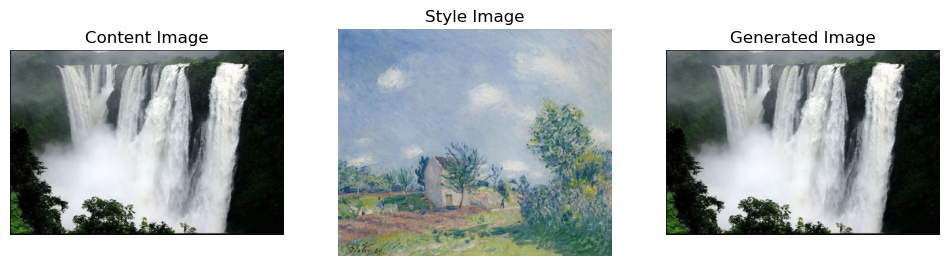

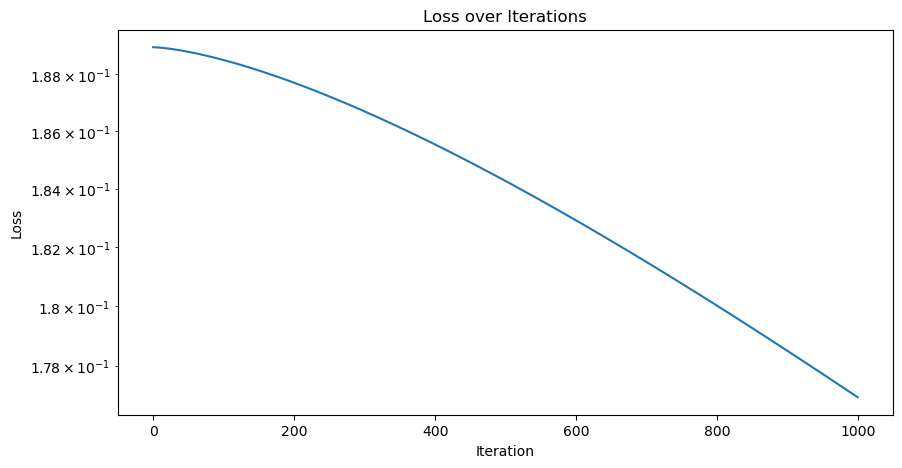

In [40]:
def style_transfer(content_image_path, style_image_path, iterations=1000, content_weight=1e4, style_weight=1e-2, tv_weight=30):
    # Load images
    content_image = load_and_process_image(content_image_path)
    style_image = load_and_process_image(style_image_path)
    
    # Normalize pixel values
    content_image = content_image / 255.0
    style_image = style_image / 255.0
    
    # Initialize generated image with content image
    generated_image = tf.Variable(content_image)
    
    # Build the CNN for feature extraction
    model = build_simple_cnn()
    
    # Specify content and style layers
    content_layers = ['block3_conv3']
    style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
    
    # Extract features once for content and style images
    content_features = model(content_image)
    style_features = model(style_image)
    
    # Filter to get only the required features
    content_dict = {}
    for i, layer_name in enumerate(content_layers):
        for j, output in enumerate(content_features):
            if layer_name == model.layers[j*3 + 2].name:  # Adjust index based on model structure
                content_dict[layer_name] = output
    
    style_dict = {}
    for i, layer_name in enumerate(style_layers):
        for j, output in enumerate(style_features):
            if layer_name in model.layers[j*3 + 2].name:  # Adjust index based on model structure
                style_dict[layer_name] = output
    
    # Create optimizer
    optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    
    # Store best result
    best_loss = float('inf')
    best_image = None
    
    # Lists to track progress
    loss_history = []
    
    # Training loop
    start_time = time.time()
    for i in range(iterations):
        with tf.GradientTape() as tape:
            # Get features of generated image
            generated_features = model(generated_image)
            
            # Calculate losses
            c_loss = 0
            s_loss = 0
            
            # Content loss
            for j, layer_name in enumerate(content_layers):
                for k, output in enumerate(generated_features):
                    if layer_name == model.layers[k*3 + 2].name:
                        layer_content_loss = content_loss(content_dict[layer_name], output)
                        c_loss += layer_content_loss / len(content_layers)
            
            # Style loss
            for j, layer_name in enumerate(style_layers):
                for k, output in enumerate(generated_features):
                    if layer_name in model.layers[k*3 + 2].name:
                        layer_style_loss = style_loss(style_dict[layer_name], output)
                        s_loss += layer_style_loss / len(style_layers)
            
            # Total variation loss for smoothness
            tv_loss = total_variation_loss(generated_image)
            
            # Total loss
            total_loss = content_weight * c_loss + style_weight * s_loss + tv_weight * tv_loss
            loss_history.append(total_loss.numpy())
            
            # Save best result
            if total_loss < best_loss:
                best_loss = total_loss
                best_image = generated_image.numpy()
        
        # Calculate gradients and apply updates
        grads = tape.gradient(total_loss, generated_image)
        optimizer.apply_gradients([(grads, generated_image)])
        
        # Ensure pixel values stay in [0, 1]
        generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))
        
        # Print progress
        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {total_loss.numpy()}")
    
    end_time = time.time()
    print(f"Total time: {end_time - start_time:.2f} seconds")
    
    # Convert best result to image
    best_image = tf.clip_by_value(best_image, 0, 1) * 255
    best_image = tf.cast(best_image, tf.uint8)
    best_image = best_image[0]  # Remove batch dimension
    
    # Plot and save results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(tf.cast(content_image[0] * 255, tf.uint8))
    plt.title('Content Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(tf.cast(style_image[0] * 255, tf.uint8))
    plt.title('Style Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(best_image)
    plt.title('Generated Image')
    plt.axis('off')
    
    plt.savefig('style_transfer_result.png')
    plt.show()
    
    # Plot loss history
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title('Loss over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.savefig('loss_history.png')
    plt.show()
    
    # Save generated image
    plt.imsave('generated_image.png', tf.cast(best_image, tf.uint8).numpy())
    
    return best_image

# Example usage:
if __name__ == "__main__":
    content_path = "2.JPG"  # Replace with your content image path
    style_path = "Alfred_Sisley_123.jpg"      # Replace with your style image path
    
    result = style_transfer(
        content_path, 
        style_path,
        iterations=1000,       # Increase for better results
        content_weight=1e4,    # Adjust to control content preservation
        style_weight=1e-2,     # Adjust to control style transfer strength
        tv_weight=30           # Adjust to control smoothness
    )